# <center> **Deep style transfer** </center>

## <center> Machine Learning Programming Exercise 9</center>




| <font size=6,font color='red'>Monôme / binôme</font> | <font size=6,font color='red'>Nom</font> | <font size=6,font color='red'>Prénom</font> |
|:-------------: |:----------- |:------ |
| monôme/binôme 1 | <span style="color:red">Roudaut</span> | <span style="color:red">Tanguy</span> |
| binôme 2 | <span style="color:red">Dubée</span> | <span style="color:red">Melvin</span> |

Ce tutoriel utilise l'apprentissage profond pour composer une image dans le style d'une autre image.
(Vous avez déjà souhaité peindre comme Picasso ou Van Gogh ?)
C'est ce qu'on appelle le *Neural Style Transfer* et la technique est décrite dans <a href="https://arxiv.org/abs/1508.06576" class="external">A Neural Algorithm of Artistic Style (Gatys et al., 2015)</a> .

Dans ce tp, vous:
- créérez l'algorithme du transfert de style à partir d'un réseau de neurones,
- générerez des images _artistiques_ en utilisant votre algorithme.

La plupart des algorithmes que vous avez étudiés optimisent une fonction de coût pour obtenir un ensemble de valeurs de paramètres. Dans le Neural Style Transfer, vous optimiserez une fonction de coût pour obtenir des valeurs de pixels.


Le transfert de style neuronal est une technique d'optimisation utilisée pour:
- considérer en entrée, deux images:
 - une image **(C)** de *contenu*
 - et une image **(S)** de *référence de style* (telle qu'une œuvre d'art d'un peintre célèbre)
- et les fusionner de sorte que l'image de sortie **(G)** ressemble à l'image de contenu, mais " peinte " dans le style de l'image de référence de style.

Cette opération est réalisée en optimisant l'image de sortie pour qu'elle corresponde aux statistiques de contenu de l'image de contenu et aux statistiques de style de l'image de référence de style. Ces statistiques sont extraites des images à l'aide d'un réseau de neurones convolutif (CNN). Par exemple, le contenu de la figure ci-dessous est une photo de paysage prise dans le parc national du Mont Rainier, dans la banlieue de Seattle, tandis que l'image de style est une peinture à l'huile sur le thème des chênes d'automne. Dans l'image synthétisée de sortie, les coups de pinceau à l'huile de l'image de style sont appliqués, ce qui permet d'obtenir des couleurs plus vives, tout en préservant la qualité de l'image.

<img src="https://drive.google.com/uc?id=1zQ4DbImMazHaTgbjmpnvc5GsG7L-lWlZ" width="650px"/>

[Extrait de Dive into Deep Learning](https://d2l.ai/)

Pour un autre exemple, prenons l'image de ce chien et la composition 7 de Wassily Kandinsky et posons nous la question: à quoi cela ressemblerait-il si Kandinsky décidait de peindre le tableau de ce chien exclusivement dans ce style ? Quelque chose comme ça ?

<table class="tfo-notebook-buttons" align="center">
<tbody>
  <td>
     <img src="https://drive.google.com/uc?id=1m4UpjKznLNiIr4ntYrYFNcOAHpKs0g_d" width="200px"/>
<img src="https://drive.google.com/uc?id=1v1yefr7dSJ3lopo566ntBON09j-uAZyq " width="200px"/>
      <!--     [Yellow Labrador Looking](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg), from Wikimedia Commons by [Elf](https://en.wikipedia.org/wiki/User:Elf). License [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/deed.en)
      -->
 </td>
  <td>
<img src="https://drive.google.com/uc?id=14U1b9qLiDDleD-oug7_AaUTduhkFAWj5" width="400px"/>
  </td>
</tbody>
</table>

## 1. Setup (Configuration)


## 1.1 Colab or not colab

In [1]:
# common imports
import sys,os,glob

# Colab preamble
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:

  # mount google drive directories
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

  # replace the ipynb_name (below) with the name of your jupyter notebook file

  # ----------- Your code here --------------------->

  ipynb_name = 'style_transfer_startercode.ipynb'

  # ------------------------------------------------>

  ipynb_name = glob.glob(os.getcwd() + '/**/' + ipynb_name, recursive = True)
  code_folder = os.path.dirname(ipynb_name[0])

  # change to the right folder
  %cd "$code_folder"
  !ls

Mounted at /content/gdrive
/content/gdrive/MyDrive/Machine_Learning
checkpoint				   partie2.ipynb
contents				   styles
my_keras_model.h5			   style_transfer_startercode.ipynb
my_keras_weights.ckpt.data-00000-of-00001  tp2.1_tuto_cnns_startercode.ipynb
my_keras_weights.ckpt.index		   tp2.2_learning_cnns_fine_tuning_startercode.ipynb
partie1.ipynb				   tp2.2_learning_cnns_from_scratch_startercode.ipynb


### 1.2 Importer et configurer des modules

In [2]:
# common imports
import numpy as np

# display imports
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
matplotlib.rc('animation', html='jshtml') # To get smooth animations
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False
import PIL.Image
# import time


# machine learning packages
import tensorflow as tf

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IN_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

elif len(tf.config.list_physical_devices('GPU')) > 1:
  # a décommenter si problème avec le GPU de votre machine
  physical_devices = tf.config.experimental.list_physical_devices('GPU')

  for gpu in physical_devices:
      tf.config.experimental.set_memory_growth(gpu, True)



# Load compressed models from tensorflow_hub
import tensorflow_hub as hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

# import connected to display
import IPython.display as display




### 1.3 fonctions utiles

In [3]:
# fonction qui permet d'afficher une image à partir des sorties de tf
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [4]:
# fonction pour charger une image et limiter sa dimension maximale à 512 pixels.
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [5]:
# fonction d'affichage d'une image
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

### 1.3 images de contenu et de style

**Choisissez une image de style et une image de contenu : vous pouvez garder les images proposées dans un premier temps**

In [9]:
# chemin du répertoire des fichiers de contenus
content_folder = './contents/'

# chemin du fichier de contenu
content_path = content_folder+'brest3.jpg'

# chemin du répertoire des fichiers de styles
style_folder = './styles/'

# chemin du fichier de style
style_path = style_folder+'wave.jpg'



## 2. Visualiser les entrées

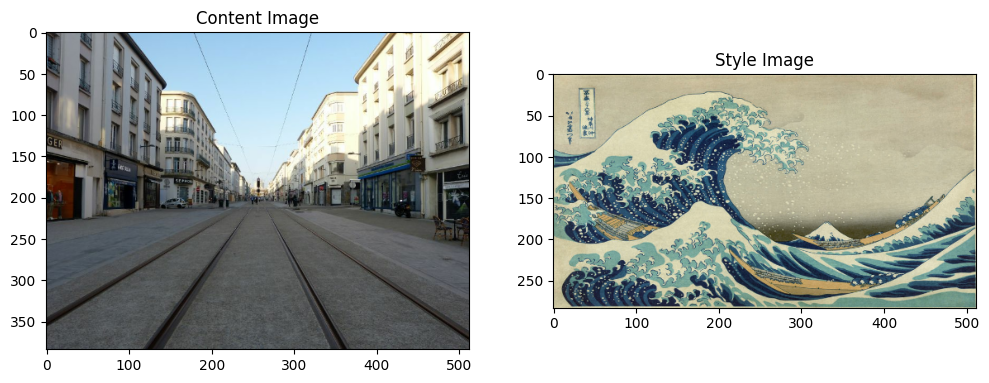

In [10]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## 3. Fast Style Transfer en utilisant le modèle de TF_Hub

Il existe un hub (tensorflow_hub) regroupant les différents modèles pré-entrainés de réseau de neurones pouvant être utilisés par tensorflow. Avant de voir et programmer l'algorithme, vous pouvez charger le [modèle associé au tranfert de style](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2).

Pour cela, il suffit d'exécuter les trois lignes suivantes:

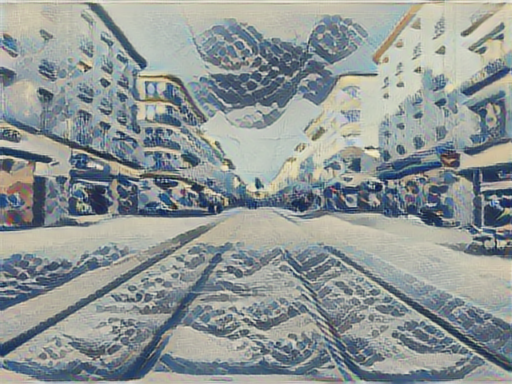

In [11]:
# chargement du modèle
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

# application du modèle pour une image de contenu et de style
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]

# plot image
tensor_to_image(stylized_image)

## 4. Principe de la méthode

Le transfert de style neuronal (NST) utilise un réseau convolutif préalablement entrainé. L'idée d'utiliser un réseau pré-entrainé sur une tâche différente et de l'appliquer à une nouvelle tâche est appelée __apprentissage par transfert__. Vous avez déjà rencontré ce type d'apprentissage lors de l'apprentissage d'un modèle de classification par __fine tuning__.

<img src="https://drive.google.com/uc?id=1dt3af2pYZbiwXi8lCcEvA7NHgjFvzqWO" width="450px"/>

La figure ci-dessus illustre la méthode de transfert de style basée sur CNN à l'aide d'un exemple simplifié.
- **Initialiser** l'image synthétisée (par exemple random ou par le contenu).
 - cette image synthétisée est un ensemble de pixels représentant les **variables** qui seront mises à jour pendant le processus de transfert de style, c'est-à-dire que ce sont les seuls paramètres du modèle qui doivent être mis à jour pendant l'apprentissage.
- **Choisir un modèle CNN pré-entraîné** pour extraire les caractéristiques (features) de l'image.
- **Fixer les paramètres** de ce modèle pendant l'apprentissage.
- **Choisir la sortie de certaines de ces couches** en tant que caractéristiques de contenu ou de style. Un CNN utilise plusieurs couches pour extraire les caractéristiques hiérarchiques des images.
- **Calculer la fonction de coût du transfert de style** par propagation avant (direction des flèches pleines) et **Mettre à jour les paramètres** du modèle (l'image synthétisée en sortie) par back-propagation (direction des flèches pointillées). La fonction de coût couramment utilisée dans le transfert de style se compose de **trois parties** :
  - (i) le **coût de contenu** rend l'image synthétisée et l'image de contenu proches pour les caractéristiques de contenu
  - (ii) le **coût de style** rend l'image synthétisée et l'image de style proches pour les caractéristiques de style
  - (iii) le **coût de variation totale** permet de réduire le bruit dans l'image synthétisée en sortie.
- Enfin, lorsque l'apprentissage du modèle est terminé, nous avons **généré l'image synthétisée finale**.

Dans l'exemple de la figure, la deuxième couche du réseau de neurones convolutionnel pré-entraîné produit les caractéristiques de contenu, et les première et troisième couches produisent les caractéristiques de style.
En suivant l'article original du NST (https://arxiv.org/abs/1508.06576), nous utiliserons le réseau VGG. Plus précisément, nous utiliserons le VGG-19, une version à 19 couches du réseau VGG. Ce modèle a déjà été entraîné sur la très grande base de données ImageNet, et a donc appris à reconnaître une variété de caractéristiques de bas niveau (aux premières couches) et de haut niveau (aux couches plus profondes).

## 5 Chargement du modèle préentrainé

**Question: Chargez le modèle [VGG19](https://keras.io/api/applications/vgg/#vgg19-function) et testez-le sur l'image de contenu pour vous assurer qu'il est utilisé correctement :**

In [31]:
# ----------- Your code here --------------------->

# chargez le modèle vgg19 avec son classifieur (include_top=True)
# hint: regardez comment on a fait pour le fine tuning

# chargement du modèle
vgg = tf.keras.applications.VGG19(weights="imagenet", include_top=True)


# prétraitez l'image de contenu par le modèle (i.e. preprocess_input)
# hint: regardez comment on a fait pour le fine tuning
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)


# utilisez tf.image.resize pour redimensionner l'image en 224x244 pixels
# uniquement utile pour la prédiction avec classifieur
resized_image = tf.image.resize(x, [224, 224])

# testez l'image de contenu par le modèle
predicted_probabilities = vgg.predict(resized_image)

# ------------------------------------------------>

print('Le nombre de classe est de: {}'.format(predicted_probabilities.shape))


1/1 [==============================] - 0s 162ms/step
Le nombre de classe est de: (1, 1000)


On peut décoder ces probabilités pour découvrir leurs classes correspondantes.

In [33]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(predicted_probabilities)[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

35363/35363 [==============================] - 0s 0us/step


[('streetcar', 0.46977118),
 ('traffic_light', 0.13666765),
 ('trolleybus', 0.06739569),
 ('cab', 0.047997054),
 ('street_sign', 0.03931028)]

**Question: Chargez le modèle [VGG19](https://keras.io/api/applications/vgg/#vgg19-function) sans son classifieur et listez les noms des couches**



In [34]:
# ----------- Your code here --------------------->

# chargez le modèle vgg19 sans son classifieur
# chargement du modèle
vgg = tf.keras.applications.VGG19(weights="imagenet", include_top=False)

# ------------------------------------------------>

# affichage des noms des layers
for (ilayer,layer) in enumerate(vgg.layers):
  print('layer {}: {}'.format(ilayer,layer.name))



layer 0: input_10
layer 1: block1_conv1
layer 2: block1_conv2
layer 3: block1_pool
layer 4: block2_conv1
layer 5: block2_conv2
layer 6: block2_pool
layer 7: block3_conv1
layer 8: block3_conv2
layer 9: block3_conv3
layer 10: block3_conv4
layer 11: block3_pool
layer 12: block4_conv1
layer 13: block4_conv2
layer 14: block4_conv3
layer 15: block4_conv4
layer 16: block4_pool
layer 17: block5_conv1
layer 18: block5_conv2
layer 19: block5_conv3
layer 20: block5_conv4
layer 21: block5_pool


## 6. Définir la fonction de coût (la tâche à réaliser)

Comme évoqué précédemment, la fonction de coût couramment utilisée dans le transfert de style se compose de **trois parties** :
  - (i) le **coût de contenu** $J_{content}(C,G)$ rend l'image synthétisée et l'image de contenu proches pour les caractéristiques de contenu
  - (ii) la **coût de style** $J_{style}(S,G)$ rend l'image synthétisée et l'image de style proches pour les caractéristiques de style
  - (iii) la **coût de variation totale** permet de réduire le bruit dans l'image synthétisée en sortie. Pour le moment, nous n'en tiendrons pas compte.

- La fonction de coût totale est alors $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$.


Comme vous l'avez vu dans les vidéos et dans le préambule, le choix de $J_{content}(C,G)$ et de $J_{style}(S,G)$ consiste premièrement à choisir les couches d'activation (après les non-linéarités) à partir desquelles on va imiter les sorties (features) pour `coller` au contenu ou au style.

Comme vous l'avez vu dans les vidéos, les premières couches en partant de la couche d'entrée du réseau (moins profondes, en amont du réseau) d'un CNN ont tendance à détecter les caractéristiques de bas niveau telles que les bords et les textures simples, et les dernières couches (plus profondes, en aval du réseau) ont tendance à détecter les caractéristiques de plus haut niveau telles que des textures plus complexes (des parties d'objet comme les *roues* ou les *yeux*) ou même les classes d'appartenance d'objet.

Alors pourquoi ces sorties intermédiaires de notre réseau de classification d'images pré-entraîné nous permettent-elles de définir des représentations de style et de contenu ?

À un haut niveau, pour qu'un réseau puisse effectuer une classification d'images (ce pour quoi ce réseau a été entraîné), il doit comprendre l'image. Cela nécessite de prendre l'image brute comme entrée et de construire une représentation interne qui convertit les pixels de l'image brute en une compréhension des caractéristiques complexes présentes dans l'image.

C'est également une des raisons pour lesquelles les réseaux neuronaux convolutifs sont capables de généraliser : ils sont capables de capturer les invariances et les caractéristiques définissant les classes (par exemple, chats vs chiens) qui sont agnostiques/indépendantes au bruit de fond et autres nuisances. Ainsi, quelque part entre l'entrée de l'image brute dans le modèle et l'étiquette de classification de sortie, le modèle sert d'extracteur de caractéristiques complexes. En accédant aux couches intermédiaires du modèle, vous êtes en mesure de décrire le contenu et le style des images d'entrée.

### 6.1 Choisir la fonction de coût de contenu  $J_{content}(C,G)$


#### 6.1.1 **Choix des couches d'activation de contenu**

Nous aimerions que l'image "générée" G ait un contenu similaire à celui de l'image d'entrée C. En pratique, vous obtiendrez les résultats les plus agréables visuellement si vous choisissez une couche au milieu du réseau - ni trop proche des entrées, ni trop profonde.


**Question: Choisissez des couches intermédiaires du réseau pour représenter le contenu de l'image :**

In [42]:
# ----------- Your code here --------------------->
# choisissez la liste des layers de contenu (dans un premier temps, garder ce choix)
content_layers = ['block3_conv2']

# ------------------------------------------------>

# variable utile pour la suite
num_content_layers = len(content_layers)


#### 6.1.2 Extraire les features de contenu
Les réseaux de `tf.keras.applications` sont conçus de manière à ce que vous puissiez facilement extraire les valeurs des couches intermédiaires à l'aide de l'API fonctionnelle de Keras.

Pour définir un modèle d'extraction de features à l'aide de l'API fonctionnelle, spécifiez les entrées et les sorties : `model = Model(inputs, outputs)`

La fonction suivante construit un modèle VGG19 qui renvoie une liste de sorties de couches intermédiaires `layer_names`:

In [40]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Charger le modèle vgg19 préentrainé sur les données imagenet
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

    # fixer les paramètres pour l'apprentissage
    vgg.trainable = False

    # liste des sorties des couches souhaitées
    outputs = [vgg.get_layer(name).output for name in layer_names]

    # construction du nouveau modèle
    model = tf.keras.Model([vgg.input], outputs)

    return model

Et pour créer et tester le modèle :

In [43]:
# création d'un modèle d'extraction de features de style
content_extractor = vgg_layers(content_layers)

# pretraitement de l'image
content_image_p = content_image*255

# Extraction des features de style pour l'image style_image
content_outputs = content_extractor(content_image*255)

# Estimation des statistiques pour les sorties de chaque couche
for name, output in zip(content_layers, content_outputs):
    print('------------------------>')
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

# plt.figure(); plt.imshow(content_outputs[0][0,:,:])

------------------------>
block3_conv2
  shape:  (96, 128, 256)
  min:  0.0
  max:  12049.045
  mean:  154.7564



#### 6.1.3 **Choix de la fonction de coût de contenu**

Supposons donc que vous ayez choisi d'utiliser une couche $l$ cachée particulière.

- Présentez l'image C en entrée du réseau VGG pré-entraîné, et appliquez le modèle (forward propagation).

Soit $a^{[l](C)}$ les activations de la couche cachée dans la couche que vous avez choisie. Ce sera un tenseur $n_H \times n_W \times n_C$.

- Répétez ce processus avec l'image G : définissez G comme entrée, et exécutez la forward propagation. Soit $a^{[l](G)}$ l'activation de la couche cachée correspondante. Nous définirons la fonction de coût du contenu comme suit :

$$J^{[l]}_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{[l](C)} - a^{[l](G)})^2\tag{1} $$

Ici, $n_H, n_W$ et $n_C$ sont la hauteur, la largeur et le nombre de canaux de la couche cachée que vous avez choisie, et apparaissent dans un terme de normalisation dans le coût. Pour plus de clarté, notez que $a^{[l](C)}$ et $a^{[l](G)}$ sont les volumes correspondant aux activations d'une couche cachée.

Similaire à la loss function en régression linéaire, la fonction de coût de contenu mesure la différence entre les features de l'image de contenu et les features de l'image synthétisée.


**Question: Codez la fonction de coût de contenu pour une couche (layer)**


In [48]:
def content_loss_layer(a_C, a_G):

# ----------- Your code here --------------------->

    # Retrouver les dimensions de a_G (≈1 line, get_shape, as_list)
    n_H, n_W, n_C = a_G.get_shape().as_list()

    # calcul de la fonction de cout (tf.reduce_sum)
    rst = (1/(4*n_H * n_W * n_C)) * tf.reduce_sum(tf.square(tf.subtract(a_C, a_G)))

# ------------------------------------------------>

    return rst


**Testez la fonction `content_loss_layer`**

In [49]:
# on fixe l'aléatoire
tf.random.set_seed(1)


# choix de a_C et a_G
a_C = content_outputs[0]
a_G = tf.random.normal(a_C.shape, mean=1, stddev=4)

# calcul du coût de contenu
J_content = content_loss_layer(a_C, a_G)
print("J_content = " + str(J_content.numpy()))

J_content = 24109.828


**Expected Output**:

<table>
    <tr>
        <td>
            **J_content**
        </td>
        <td>
           24109.83
        </td>
    </tr>

</table>

**La fonction suivante calcul le coût de contenu pour un nombre quelconque de layers **

In [50]:
def content_cost(content_targets, content_outputs):

    tmp = [content_loss_layer(content_target, content_output)
                        for content_target, content_output in zip(content_targets, content_outputs)]
    J_content = tf.add_n(tmp)


    return J_content


**Pour tester la fonction, nous allons d'abord créer un objet permettant d'extraire les features de contenu:**

In [51]:
class ContentModel(tf.keras.models.Model):
  def __init__(self, content_layers):
    super(ContentModel, self).__init__()

    self.vgg = vgg_layers(content_layers) # le modèle sort les features de contenu
    self.vgg.trainable = False # on fixe les paramètres pour l'apprentissage
    self.content_layers = content_layers # nom des couches de contenu

  def call(self, inputs):

    # preprocess inputs
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)

    # forward pass
    content_outputs = self.vgg(preprocessed_input)

    return content_outputs

Ce qui permet de tester la fonction content cost

In [52]:
# création du modèle d'extraction de features de contenu
content_extractor = ContentModel(content_layers)

# extraction de features de contenu
content_targets = content_extractor(content_image)

# features de contenu cible
content_outputs = [tf.random.normal(content_output.shape) for i, content_output in enumerate(content_outputs)]

# mesures de la similarité entre les deux via la fonction de cout
content_cost(content_outputs, content_targets)


<tf.Tensor: shape=(), dtype=float32, numpy=17379.455>

### 6.2 Choisir la fonction de coût de style $J_{style}(S,G)$

#### 6.2.1 **Choix des couches d'activation de style**

Pour la fonction de coût de style, il s'agit d'imiter des informations locales et globales et ainsi avoir des features venant des différents niveaux d'abstraction du réseau.


**Question: Choisissez des couches intermédiaires du réseau pour représenter le style de l'image :**

In [53]:
# ----------- Your code here --------------------->

# choisissez la liste des layers de style
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# variable utile pour la suite
num_style_layers = len(style_layers)

# ------------------------------------------------>

#### 6.2.2 Extraire les features de style
De la même manière, la fonction `vgg_layers` définie précédemment permet d'extraire les features de style à partir du modèle suivant:

In [54]:
# création d'un modèle d'extraction de features de style
style_extractor = vgg_layers(style_layers)

# Extraction des features de style pour l'image style_image
style_outputs = style_extractor(style_image*255)

# Estimation des statistiques pour les sorties de chaque couche
for name, output in zip(style_layers, style_outputs):
    print('------------------------>')
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

------------------------>
block1_conv1
  shape:  (1, 283, 512, 64)
  min:  0.0
  max:  723.07404
  mean:  31.025566

------------------------>
block2_conv1
  shape:  (1, 141, 256, 128)
  min:  0.0
  max:  3439.768
  mean:  182.62827

------------------------>
block3_conv1
  shape:  (1, 70, 128, 256)
  min:  0.0
  max:  9064.301
  mean:  167.78822

------------------------>
block4_conv1
  shape:  (1, 35, 64, 512)
  min:  0.0
  max:  17980.34
  mean:  670.36206

------------------------>
block5_conv1
  shape:  (1, 17, 32, 512)
  min:  0.0
  max:  2495.824
  mean:  51.209606



**Choix de la fonction de style**

Il s'avère que le style d'une image peut être décrit par les moyennes et les corrélations entre les différentes cartes de caractéristiques (feature map ou activation map).


En algèbre linéaire, la matrice de Gram $GM$ d'un ensemble de vecteurs $(v_{1},\dots ,v_{n})$ est la matrice des produits scalaires, dont les entrées sont ${\displaystyle GM_{ij} = v_{i}^T v_{j}/(2 \times n_H \times n_W})$. En d'autres termes, $GM_{ij}$ compare la similarité entre $v_i$ et $v_j$ : s'ils sont très similaires, le produit scalaire est élevé, et donc $G_{ij}$ est élevé.

Notez que plus le produit $n_H \cdot n_W$ est grand, plus les résultats dans la matrice de Gram sont grands. C'est pourquoi, il y a une normalisation par $2 \times n_H \times n_W$.

Vous pouvez calculer la matrice de Gram en multipliant la matrice de filtres "vectorisée" (flatten) par leur transposée :
<img src="imgs/NST_GM.png" style="width:900px;height:300px;">

Le résultat est une matrice de dimension $(n_C,n_C)$ où $n_C$ est le nombre de filtres. La valeur $GM_{ij}$ mesure la similarité entre les activations du filtre $i$ et les activations du filtre $j$.

Une partie importante de la matrice de Gram est que les éléments diagonaux $GM_{ii}$ mesurent également l'activité du filtre $i$. Par exemple, supposons que le filtre $i$ détecte des textures verticales dans l'image. Alors $GM_{ii}$ mesure la fréquence des textures verticales dans l'image dans son ensemble : Si $GM_{ii}$ est grand, cela signifie que l'image a beaucoup de textures verticales.

En capturant l'importance des différents types de caractéristiques ($GM_{ii}$), ainsi que le nombre de caractéristiques différentes présentes ensemble ($GM_{ij}$), la matrice de style $G$ mesure le style d'une image.


La fonction suivante permet de calculer la matrice de Gram pour une matrice en entrée ou un tenseur

In [55]:
def gram_matrix(input_tensor):

    # produit matriciel sur les éléments ij
    GM = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)

    # normalisation
    input_shape = tf.shape(input_tensor)
    num_locations = 2*tf.cast(input_shape[1]*input_shape[2], tf.float32)
    GM /= num_locations

    return GM



**Pour tester cette fonction:**

In [56]:
# test de la fonction
tf.random.set_seed(1)
A = tf.random.normal([1, 3, 3,2*1], mean=1, stddev=4)
GM = gram_matrix(A)

print("GM = " + str(GM.numpy()))


GM = [[[4.4117     0.05906227]
  [0.05906227 5.7787175 ]]]


**Expected Output**:

<table>
    <tr>
        <td>
            **GM**
        </td>
        <td>
           [[[4.4117     0.05906195]
  [0.05906195 5.7787175 ]]]
        </td>
    </tr>

</table>

Après avoir calculé la matrice de style (matrice de Gram), votre objectif sera de minimiser la distance entre la matrice de Gram de l'image "style" S et celle de l'image "générée" G. Pour l'instant, nous n'utilisons qu'une seule couche cachée $a^{[l]}$, et le coût de style correspondant pour cette couche est défini comme suit :

$$J_{style}^{[l]}(S,G) = \frac{1}{{n_C}^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(GM^{(S)}_{ij} - GM^{(G)}_{ij})^2\tag{2} $$

où $GM^{(S)}$ et $GM^{(G)}$ sont respectivement les matrices de Gram de l'image "style" et de l'image "générée", calculées en utilisant les activations de la couche cachée $l$.  

Notez que la hauteur et la largeur de la matrice de Gram sont toutes les deux le nombre de canaux $n_C$. Pour permettre à la perte de style de ne pas être affectée par ces valeurs, la fonction de coût du style $J_{style}^{[l]}(S,G)$ divise la matrice de Gram par le nombre de ses éléments, c'est-à-dire $n_c $. Avec la différence au carré, on obtient ${n_C}^2$.



**Question: Calculez la fonction de coût pour une couche (layer) l**

In [57]:
def style_cost_layer(a_S, a_G):

# ----------- Your code here --------------------->
    # Retrouver les dimensions de a_G (≈1 line) get_shape, as_list
    n_b, n_H, n_W, n_C = a_G.get_shape().as_list()

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Calculer la fonction de coût du style (≈1 ligne)
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS, GG))) / (n_C**2)

# ------------------------------------------------>

    return J_style_layer


**Test de la fonction**

In [58]:
tf.random.set_seed(1)
a_S = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)

J_style_layer = style_cost_layer(a_S, a_G)

print("J_style_layer = " + str(J_style_layer.numpy()))


# test de la fonction avec style_outputs
a_S = style_outputs[0]
a_G = tf.random.normal(style_outputs[0].shape, mean=1, stddev=4)

J_style_layer = style_cost_layer(a_S, a_G)
print("J_style_layer = " + str(J_style_layer.numpy()))


J_style_layer = 14.017806
J_style_layer = 8938997.0


**Expected Outputs**:

<table>
    <tr>
        <td>
            **J_style_layer**
        </td>
        <td>
           14.017806
        </td>
    </tr>

</table>
<table>
    <tr>
        <td>
            **J_style_layer**
        </td>
        <td>
           8938998.0
        </td>
    </tr>

</table>

**La fonction suivante calcule le coût de style pour un nombre quelconque de layers**

In [59]:
def style_cost(style_targets, style_outputs):

    tmp = [style_cost_layer(style_targets[i],style_output) for i, style_output in enumerate(style_outputs)]
    J_style = tf.add_n(tmp)

    return J_style


**Pour tester la fonction, nous allons d'abord créer un objet permettant d'extraire les features de style:**

In [60]:
class StyleModel(tf.keras.models.Model):
  def __init__(self, style_layers):
    super(StyleModel, self).__init__()

    self.vgg = vgg_layers(style_layers) # le modèle sort les features de style puis de contenu
    self.vgg.trainable = False # on fixe les paramètres pour l'apprentissage
    self.style_layers = style_layers # nom des couches de style
    self.num_style_layers = len(style_layers)

  def call(self, inputs):

    # preprocess inputs
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)

    # forward pass
    style_outputs = self.vgg(preprocessed_input)

    return style_outputs

**Test de la fonction**

In [61]:
# création du modèle d'extraction de feature de style
style_extractor = StyleModel(style_layers)

# Extraction de feature de style pour l'image de style
style_targets = style_extractor(style_image)

# Extraction de feature de style pour l'image de contenu
style_outputs = style_extractor(content_image)

# Similarité entre les features
style_cost(style_targets,style_outputs)

<tf.Tensor: shape=(), dtype=float32, numpy=19937085000.0>

**Expected Outputs**:

<table>
    <tr>
        <td>
            style_cost
        </td>
        <td>
          19937085000.0
        </td>
    </tr>

</table>


### 6.3 Définir la fonction de coût totale $J(G)$

Enfin, créons une fonction de coût totale qui minimise à la fois le coût du style et celui du contenu. La formule est la suivante :
$$J(G) = \alpha / numContentLayers \times J_{content}(C,G) + \beta  / numStyleLayers \times J_{style}(S,G)$$



Fixons d'abord arbitrairement les poids de chaque contribution. Vous pourrez essayer différentes valeurs.

In [62]:
alpha = style_weight = 1e-2 / num_style_layers
beta = content_weight = 1e2 / num_content_layers

**Question: codez cette fonction de coût totale:**

In [71]:
def style_content_loss(style_outputs, content_outputs):

# ----------- Your code here --------------------->

    # terme de style pondéré
    style_loss = alpha * style_cost(style_targets, style_outputs)

    # terme de contenu pondéré
    content_loss = beta * content_cost(content_targets, content_outputs)

    # somme
    loss =  style_loss +  content_loss

# ------------------------------------------------>

    return loss, style_loss, content_loss

**Test de la fonction**

In [72]:
# extraction des features
style_targets = style_extractor(style_image)
content_targets = content_extractor(content_image)

style_outputs = [tf.random.normal(style_target.shape) for i, style_target in enumerate(style_targets)]
content_outputs = [tf.random.normal(content_target.shape) for i, content_target in enumerate(content_targets)]


loss, style_loss, content_loss = style_content_loss(style_outputs, content_outputs)
print(loss, style_loss, content_loss)

tf.Tensor(91000060.0, shape=(), dtype=float32) tf.Tensor(89262130.0, shape=(), dtype=float32) tf.Tensor(1737936.8, shape=(), dtype=float32)


**Expected Outputs**:

<table>
    <tr>
        <td>
            loss
        </td>
        <td>
           91000080.0
        </td>
    </tr>

</table>
<table>
    <tr>
        <td>
            style_loss
        </td>
        <td>
           89262130.0
        </td>
    </tr>

</table>
<table>
    <tr>
        <td>
            content_loss
        </td>
        <td>
           1737952.5
        </td>
    </tr>

</table>

## 7. Apprentissage par optimisation de la fonction de coût totale

Avec cet extracteur de style et de contenu, vous pouvez maintenant mettre en œuvre l'algorithme de transfert de style.

### 7.1 Définition des valeurs cibles de style et de contenu

**Question: Définissez vos valeurs cibles de style et de contenu :**

In [73]:
# ----------- Your code here --------------------->

style_targets = style_extractor(style_image)
content_targets = content_extractor(content_image)

# ------------------------------------------------>

### 7.2 Initialisation de l'image à optimiser

Définissez une `tf.Variable` pour contenir l'image à optimiser. Pour que cela soit rapide, initialisez-la avec l'image du contenu (la `tf.Variable` doit avoir la même forme que l'image du contenu) :

In [74]:
image = tf.Variable(content_image)

Puisqu'il s'agit d'une image à virgule flottante (float), définissez une fonction pour maintenir les valeurs des pixels entre 0 et 1 :

In [75]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

### 7.3 Choisir un optimiseur

**Question: Créer un optimiseur. L'article original recommande LBFGS, mais `Adam` fonctionne bien aussi. (Fixer le learning_rate à une valeur de 0.02)**

In [93]:
# ----------- Your code here --------------------->

opt_fcn = tf.keras.optimizers.legacy.Adam(learning_rate=0.02)


# ------------------------------------------------>

### 7.4 Forward and back propagation et descente de gradients

Plutôt que la fonction `fit` de `tf.keras`, nous allons utiliser `tf.GradientTape` pour réaliser la descente de gradient.
PS: notez que la fonction `fit` intègre cette manière de faire.

In [80]:
history_total_loss = []
history_style_loss = []
history_content_loss = []

# @tf.function() # si décommenter permet une implémentation plus rapide mais pas le débuggage
def train_step(image):

    # forward pass avec enregistrement de toutes les activations
    with tf.GradientTape() as tape:
        # extraction des features pour l'image à synthétiser
        style_outputs = style_extractor(image)
        content_outputs = content_extractor(image)

        # calcul de la fonction de coût
        loss, style_loss, content_loss = style_content_loss(style_outputs,content_outputs)

    # calcul des gradients par rétropropagation
    grad = tape.gradient(loss, image)

    # application des gradients aux paramètres (ici l'image) de la manière classique d'une descente de gradient
    opt_fcn.apply_gradients([(grad, image)])

    # mise à jour de l'image
    image.assign(clip_0_1(image))

    # mise à jour de l'historique
    history_total_loss.append(loss)
    history_style_loss.append(style_loss)
    history_content_loss.append(content_loss)


**Maintenant, exécutez quelques étapes pour tester :**

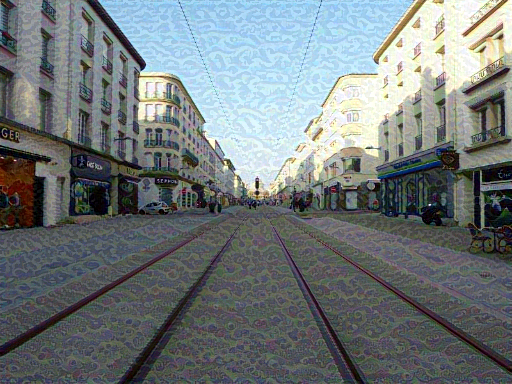

In [81]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Puisque ça marche, effectuez une optimisation plus longue :

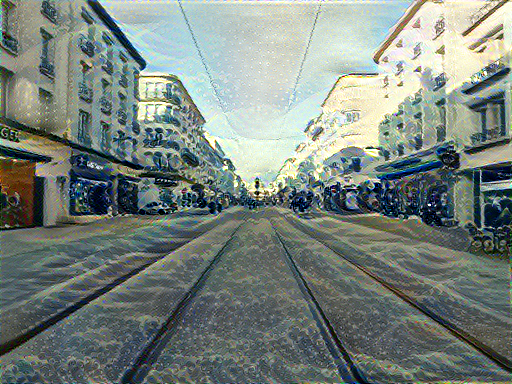

Train step: 1000
Total time: 204.4


In [82]:
# démarrage du chrono
import time
start = time.time()

# paramètres
epochs = 10
steps_per_epoch = 100

# boucle sur les épochs
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1

        # un pas de descente de gradient
        train_step(image)

        # display
        print(".", end='', flush=True)

    # display
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

# arret du chrono et affichage
end = time.time()
print("Total time: {:.1f}".format(end-start))

**On peut afficher également l'évolution du coût et observer la minimisation et la convergence.**

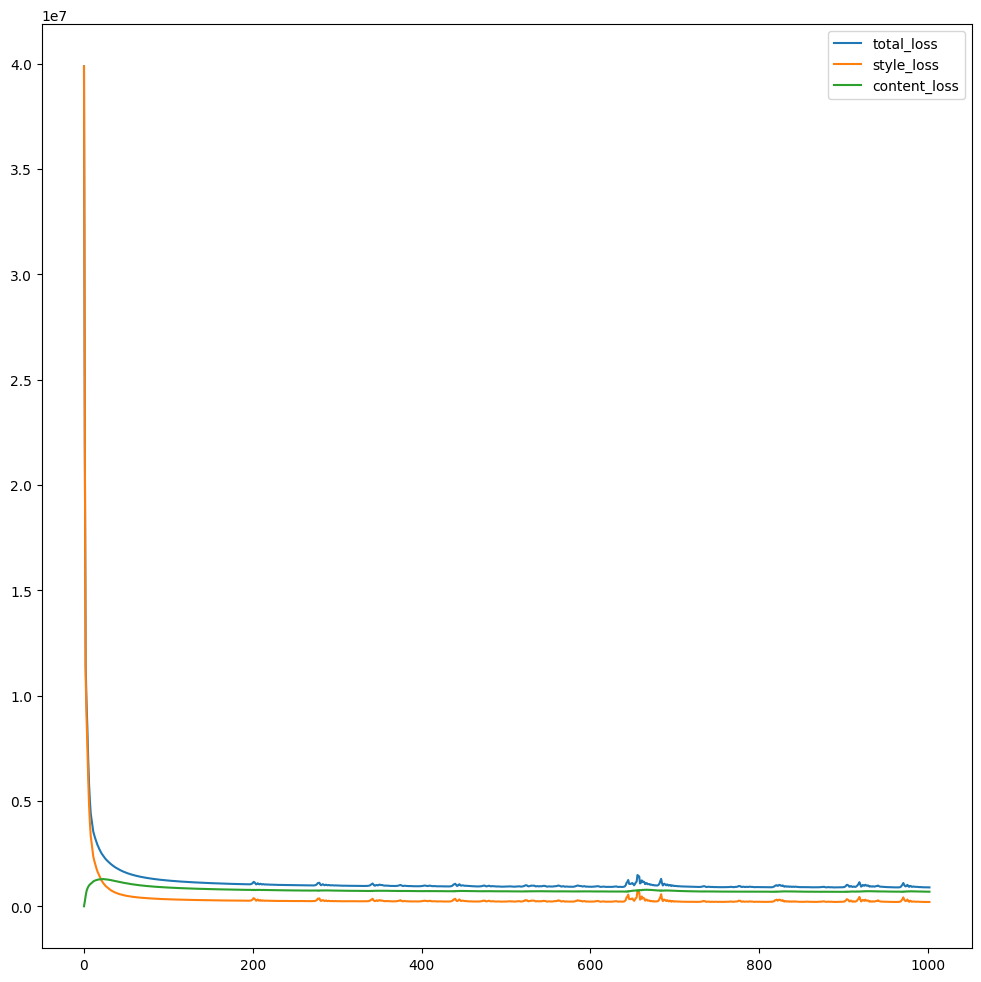

In [83]:
plt.figure();
plt.plot(history_total_loss)
plt.plot(history_style_loss)
plt.plot(history_content_loss)
plt.legend(['total_loss', 'style_loss', 'content_loss'])


## 8. Perte de variation totale

Un inconvénient de cette implémentation de base est qu'elle produit beaucoup d'artefacts liés aux hautes fréquences. Réduisez-les en utilisant un terme de régularisation explicite sur les composantes hautes fréquences de l'image. En transfert de style, ceci est souvent appelé la **perte de variation totale**.

La fonction suivant code un filtre passe-haut:

In [84]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

Ce filtre peut être testé ainsi.

In [85]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

Output hidden; open in https://colab.research.google.com to view.

Cela montre comment les composantes de haute fréquence ont augmenté.

La **fonction de coût de variation totale** est une sorte de fonction de régularisation sur ces composantes hautes fréquences. Elle peut être codée ainsi:

In [86]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [87]:
total_variation_loss(image).numpy()

87095.76

En fait, il n'est pas nécessaire de l'implémenter vous-même, TensorFlow inclut une implémentation standard qui donne le même résultat :

In [88]:
tf.image.total_variation(image).numpy()

array([87095.76], dtype=float32)

Nous allons modifier le code pour intégrer ce nouveau terme. **La contribution de ce nouveau terme doit d'abord être fixée:**

In [89]:
total_variation_weight=30

**Question: Modifiez la fonction `train_step` pour intégrer ce nouveau terme**

In [90]:
history_total_loss = []
history_style_loss = []
history_content_loss = []
history_total_variation_loss = []

#@tf.function()
def train_step(image):

    # forward pass avec enregistrement de tous les activations
    with tf.GradientTape() as tape:
        # extraction des features pour l'image à synthétiser
        style_outputs = style_extractor(image)
        content_outputs = content_extractor(image)

        # calcul de la fonction de coût
        loss, style_loss, content_loss = style_content_loss(style_outputs,content_outputs)

        # avec total variation
# ----------- Your code here --------------------->
        total_variation_loss = total_variation_weight * tf.image.total_variation(image)
        loss += total_variation_loss


# ------------------------------------------------>


    # calcul des gradients par rétropropagation
    grad = tape.gradient(loss, image)

    # application des gradients aux paramètres (ici l'image)
    opt_fcn.apply_gradients([(grad, image)])

    # mise à jour
    image.assign(clip_0_1(image))

    history_total_loss.append(loss)
    history_style_loss.append(style_loss)
    history_content_loss.append(content_loss)
    history_total_variation_loss.append(total_variation_loss)

**Réinitialisez ensuite la variable d'optimisation :**

In [91]:
image = tf.Variable(content_image)

**Et relancez l'optimisation**:

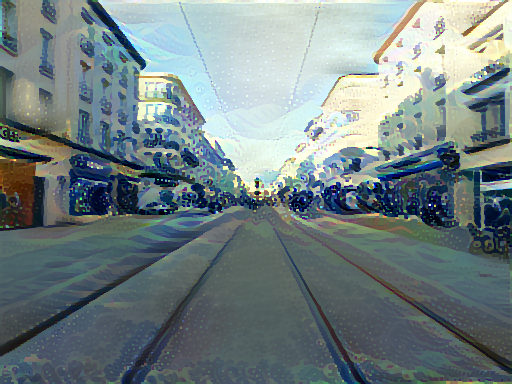

Train step: 1000
Total time: 205.3


In [94]:
# démarrage du chrono
import time
start = time.time()

# paramètres
epochs = 10
steps_per_epoch = 100

# boucle sur les épochs
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1

        # un pas de descente de gradient
        train_step(image)

        # display
        print(".", end='', flush=True)

    # display
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

# arret du chrono et affichage
end = time.time()
print("Total time: {:.1f}".format(end-start))

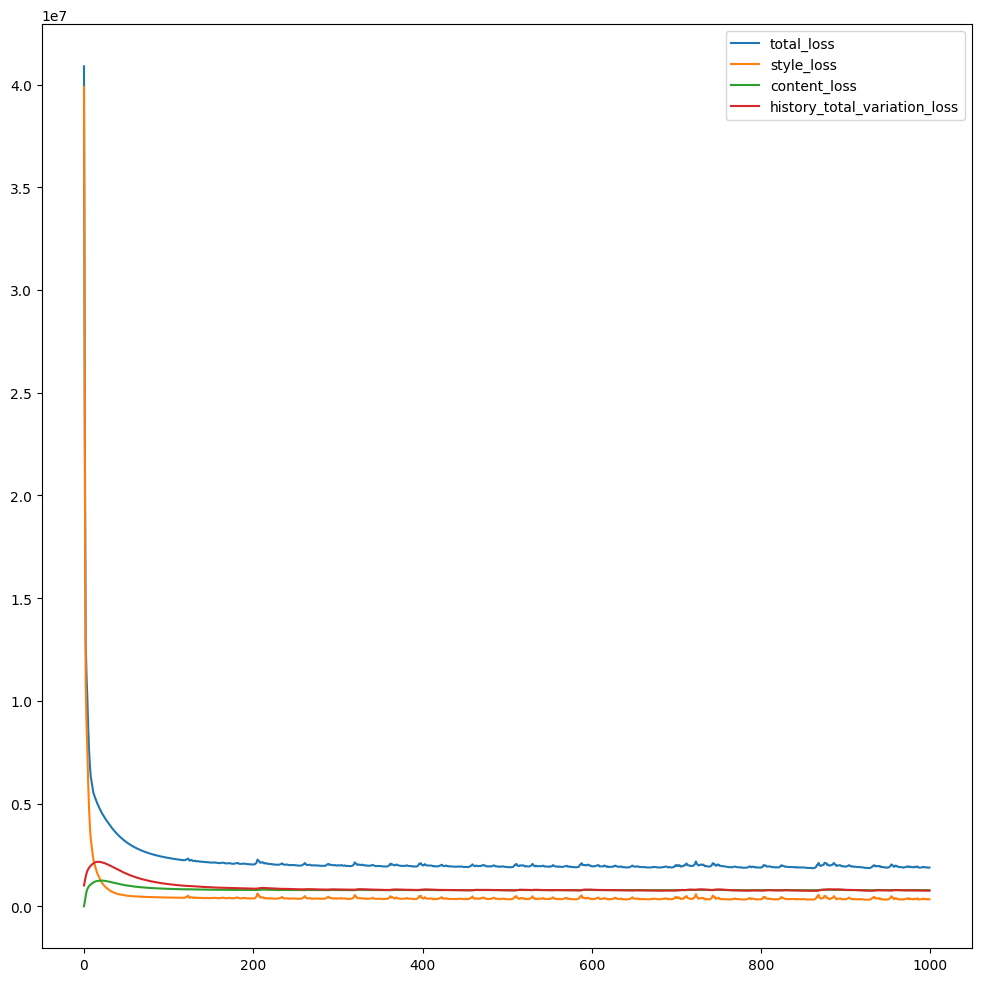

In [95]:
plt.figure();
plt.plot(history_total_loss)
plt.plot(history_style_loss)
plt.plot(history_content_loss)
plt.plot(history_total_variation_loss)
plt.legend(['total_loss', 'style_loss', 'content_loss', 'history_total_variation_loss'])


Enfin, si vous le souhaitez, sauvez l'image générée:

In [97]:
# sauve sur le disque ou dans le drive
file_name = './results/'+'stylized-image.png'
tensor_to_image(image).save(file_name)

# permet de télécharger du drive
if IN_COLAB:
    try:
      from google.colab import files
    except ImportError:
      pass
    else:
      files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>